In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1',url,
                                 untar = True,cache_dir = '.',
                                 cache_subdir = '')
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 338s 4us/step


In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [7]:
dir_to_be_removed = os.path.join(train_dir,'unsup')
shutil.rmtree(dir_to_be_removed)

In [8]:
batch_size = 32
seed = 983

raw_train = tf.keras.utils.text_dataset_from_directory('aclImdb',
                                                      validation_split = 0.2,
                                                      subset = 'training',
                                                      batch_size = batch_size,
                                                      seed = seed)

raw_val = tf.keras.utils.text_dataset_from_directory('aclImdb',
                                                      validation_split = 0.2,
                                                      subset = 'validation',
                                                      batch_size = batch_size,
                                                      seed = seed)

Found 50005 files belonging to 2 classes.
Using 40004 files for training.
Found 50005 files belonging to 2 classes.
Using 10001 files for validation.


In [9]:
for text_batch,label_batch in raw_train.take(1):
    for i in range(3):
        print('Review : ',text_batch[i])
        print('Label : ',label_batch[i])

Review :  tf.Tensor(b'No wonder most of the cast wished they never made this movie. It\'s just plain ridiculous and embarrassing to watch. Bad actors reading cheesy lines while shiny classic showroom cars continuously circle a diner that looks more like a Disneyland attraction. Students fist-fight with the deranged principal as he tries to stop them from setting fire to a bronze civil war statue. The Watts riots with a cast of...ugh...10?? Dermot Mulroney tries not to gag while he makes out with a Mary Hartman look-alike with the most annoying smile since \'Mr. Sardonicus\'. Noah Wyle reads Bob Dylan lyrics to the wicked teacher with a swinging pointer and very bad face lift. Drunken virgin Rick Schroder sits in a kiddie rocket on his last night before entering the service. Silly, giggling school girls dress up in leopard stretch pants and walk on the set of \'Shindig\', sing horribly off key, and actually make it big in the music business. And who wrote this compelling dialog?: "I\'m 

In [10]:
test = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                 batch_size = batch_size)

Found 25000 files belonging to 2 classes.


In [12]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
text_batch,label_batch = next(iter(raw_train))
first_review, first_label = text_batch[0], label_batch[0]
print('review',first_review)
print(first_label)
print(vectorize_text(first_review,first_label))

review tf.Tensor(b"The only thing serious about this movie is the humor. Well worth the rental price. I'll bet you watch it twice. It's obvious that Sutherland enjoyed his role.", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int32)
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   2,   61,  147,  589,   42,   11,   17,    7,    2,  462,   70,
         262,    2, 2249, 1741,  534, 2277,   22,  103,    9, 1465,   29,
         597,   12, 3067,  491,   24,  208,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  

In [20]:
train_ds = raw_train.map(vectorize_text)
val_ds = raw_val.map(vectorize_text)
test_ds = test.map(vectorize_text)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
embedding_dim = 16

In [23]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1251/1251 [==============================] - 73s 57ms/step - loss: 0.6924 - binary_accuracy: 0.5141 - val_loss: 0.6915 - val_binary_accuracy: 0.5181
Epoch 2/10
1251/1251 [==============================] - 15s 12ms/step - loss: 0.6859 - binary_accuracy: 0.5749 - val_loss: 0.6848 - val_binary_accuracy: 0.5606
Epoch 3/10
1251/1251 [==============================] - 14s 11ms/step - loss: 0.6684 - binary_accuracy: 0.6305 - val_loss: 0.6730 - val_binary_accuracy: 0.5868
Epoch 4/10
1251/1251 [==============================] - 14s 11ms/step - loss: 0.6420 - binary_accuracy: 0.6621 - val_loss: 0.6608 - val_binary_accuracy: 0.6008
Epoch 5/10
1251/1251 [==============================] - 14s 11ms/step - loss: 0.6147 - binary_accuracy: 0.6813 - val_loss: 0.6511 - val_binary_accuracy: 0.6085
Epoch 6/10
1251/1251 [==============================] - 14s 11ms/step - loss: 0.5904 - binary_accuracy: 0.6984 - val_loss: 0.6461 - val_binary_accuracy: 0.6159
Epoch 7/10
1251/1251 [==================

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.9134 - binary_accuracy: 0.4686
Loss:  0.9133660793304443
Accuracy:  0.46856001019477844


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

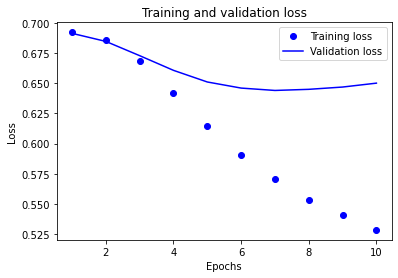

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

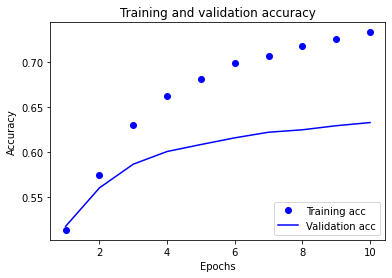

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test)
print(accuracy)

782/782 [==============================] - 14s 18ms/step - loss: 0.9134 - accuracy: 0.4686
0.46856001019477844


In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 322ms/step


array([[0.44116074],
       [0.4129345 ],
       [0.44709733]], dtype=float32)